# The Relationship Between a Hotel's Geographical Proximity to the Center of the Country and Its Price

* Yarin Cohen, ID: 211361720
* Amit Shiber, ID: 322372582

## About Our Project

<div style="display: flex; align-items: center;">
  <p style="flex: 1; margin-top: -10px;">
    From time to time, the issue of the periphery versus the center of the country comes up in the media. We decided to research more about the subject and check the hotel prices in the cities near Tel Aviv and in the distant cities. After crawling the data from the hotel website, we will use an additional function with an API to calculate distances between two locations. Is there a connection between the price of hotel charges and its proximity to the center of the country?
  </p>
  <p style="margin-left: auto;">
    <img src="images/booking_macbook-1.png" alt="Image Alt Text" width="250px" />
  </p>
</div>


### Information Sources and Data Acquisition Methods

* **Crawling Booking.com** - One of the largest online travel agencies. As of December 31, 2022, Booking.com offered lodging reservation services for approximately 2.7 million properties, including 400,000 hotels, motels, and resorts and 2.3 million homes, apartments in over 220 countries and in over 40 languages. It will help us getting data about the hotels in this project.

* **GeoDB Cities API** - Online cities database. It exposes city, region, and country data via both GraphQL and REST APIs. It will help us calculate the distance between two cities.

### Data Set Description

Each line in the data set represents a hotel.

Columns representation in the data set:
* Hotel name
* Hotel Address
* Hotel Description
* Price per night (on a fixed date, the cheapest deal)
* Score - general
* Score - stuff
* Score - facilities
* Score - convenience
* Score - value for money
* Score - location
* Score - clean
* Proximity to the center of the country (km)

### Machine Learning

* **Type of ML**: Regression

* We will start with easy regression models (one variable and low powers) and try to go through each pair of an explanatory variable and an explained variable.

* There is no rule that says how many variables make a regression heavy and sluggish. If the software starts to falter, we will stop and think whether adding the variables and holdings will contribute to the prediction or only to the complications of calculation, memory, etc. We are required to exercise discretion between predictability and complications and resources such as private time.

* If the learning results are not satisfactory, we will use
in classification and division into price levels.

## Imports

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import time
import random
from tqdm import tqdm
import pandas as pd
from unidecode import unidecode
import scipy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt #for eda
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Step 1: Defining a Research Question

<div style="display: flex; align-items: center;">
  <p style="flex: 1; margin-top: -10px;">
  Is it possible to predict the price of a night in a certain hotel, based on its proximity to the center and the score given to it by surfers in the various categories?
  </p>
  <p style="margin-left: auto;">
    <img src="images/researchQ.png" alt="Image Alt Text" width="100px" />
  </p>
</div>


## Step 2: Data Acquisition



<div style="display: flex; align-items: center;">
  <h3 style="flex: 1; margin-top: -10px; font-size: 25px;">
    Data Acquisition by Crawling
  </h3>
  <p style="margin-left: auto;">
    <img src="images/crawling.jfif" alt="Image Alt Text" width="200px" />
  </p>
</div>

First of all, we will check Booking.com's Robots.txt terms, to understand if there are any pages we can't crawl: https://booking.com/robots.txt

* We will start by searching manually on Booking's main page for a vacation in Israel, on 03-04/09/2023.

* The results page will be crawled first.
* Due to complexity of HTML elements, we will use the mobile version of Booking.
* <a href="https://www.booking.com/searchresults.he.html?ss=%D7%99%D7%A9%D7%A8%D7%90%D7%9C&ss=%D7%99%D7%A9%D7%A8%D7%90%D7%9C&group_adults=2&group_children=0&no_rooms=1&sb_travel_purpose=leisure&ssne=%D7%99%D7%A9%D7%A8%D7%90%D7%9C&ssne_untouched=%D7%99%D7%A9%D7%A8%D7%90%D7%9C&sb_changed_dates=1&label=gen173nr-1BCAEoggI46AdIM1gEaGqIAQGYAQ64AQfIAQzYAQHoAQGIAgGoAgO4AsPO_6IGwAIB0gIkN2EzYmVmMjgtNTkwYS00YjMyLWI5ZmUtMmZjMTQwOTdmM2I42AIF4AIB&sid=ae3ca57b743d1747c5f828a2fabc4587&aid=304142&lang=he&sb=1&src_elem=sb&src=searchresults&dest_id=103&dest_type=country&checkin=2024-02-01&checkout=2024-02-02&prefer_site_type=mdot" >This is</a> the first page will be crawled.

#### Auxiliary Functions

In [2]:
# Load soup object:

def loadSoupObject(url):

    headers = { "User-Agent": "Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148" }
    
    time.sleep(random.randint(1,5))
    r = requests.get(url, headers=headers).content
    
    return BeautifulSoup(r,"html.parser")

In [3]:
# Getting URLs of all the hotels in the page:

def getHotelsURL(soupObj):

    links = []
   
    for link in soupObj.findAll("a", {"data-testid" : "title"}):
        links.append(link.get("href"))

    return links

In [4]:
# Getting URL of the next results page:

def getNextPage(soupObj):
    return soupObj.find("a", {"title" : "Next page"}).get("href")

In [5]:
# Getting information from a hotel page:

def getHotelData(soupObj):

    dataOfHotel = []

    # Hotel name:
    name = soupObj.find("span",{"class" : "hp-header--title--text"})
    dataOfHotel.append(name.text if name else np.nan)

    # Hotel address:
    add = soupObj.find("span",{"class" : "js_hp_address_text_line"})
    dataOfHotel.append(add.text if add else np.nan)

    # Hotel description:
    desc = soupObj.find("div",{"class" : "page-section--content"})
    dataOfHotel.append(desc.text if desc else np.nan)
    
    # Price per night (on a fixed date, the cheapest deal):
    price = soupObj.find("div",{"class" : "prco-js-headline-price"})
    dataOfHotel.append(price.text if price else np.nan)

    # Score - general:
    score = soupObj.find("div",{"data-testid" : "review-score-component"})
    dataOfHotel.append(score.text if score else np.nan)

    # Score - value for money:
    value = soupObj.find("div",{"id" : ":R5m:-label"})
    dataOfHotel.append(value.text if value else np.nan)

    # Score - location:
    location = soupObj.find("div",{"id" : ":R4m:-label"})
    dataOfHotel.append(location.text if location else np.nan)

    # Score - clean:
    clean = soupObj.find("div",{"id" : ":R56:-label"})
    dataOfHotel.append(clean.text if clean else np.nan)

    return dataOfHotel


In [6]:
# The whole process of crawling all the hotels from results pages:

def getAllHotels(urlResults):

    currentPage = loadSoupObject(urlResults)

    resultsPages = []
    hotelsLinks = []

    # Collecting links of results pages:

    resultsPages.append(currentPage)

    for i in tqdm(range(33), desc="Collecting next-links..."):
        
        if (currentPage.find("a", {"title" : "Next page"})):
            nextPage = loadSoupObject(getNextPage(currentPage))
            resultsPages.append(nextPage)
            currentPage = nextPage

            if not (currentPage.find("a", {"title" : "Next page"})):
                break

    # Collecting links of hotels:

    for page in tqdm(resultsPages,desc="Collecting links from result pages..."):
        hotelsLinks.extend(getHotelsURL(page))

    # Crawling data from hotel pages

    hotelsData = []

    for link in tqdm(hotelsLinks, desc="Crawling hotels data..."):
        hotelsData.append(getHotelData(loadSoupObject(link)))

    return hotelsData

#### Main Function

First, we start by crawling the results pages when searching for "Israel", "Herzliya", etc. in the search bar found on the home page.
- Crawling all "next page" links found on the results pages.

- Crawling all the links of the hotel pages found in the results pages.
- Crawling the data from each hotel page.

Here we can see an array of 18 links, which were obtained as a result of searching these phrases on the homepage of Booking.com.

These links are not displayed in one place on Booking.com. Therefore, we had to copy and paste them, instead of crawling them as well.

In [7]:
searches = [
    # All of Israel:
    "https://www.booking.com/searchresults.en-us.html?ss=israel&ssne=Upper+Galilee&ssne_untouched=Upper+Galilee&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=103&dest_type=country&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=57b8636d07030080&ac_meta=GhA1N2I4NjM2ZDA3MDMwMDgwIAAoATICZW46BWlzcmFlQABKAFAA&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Herzelia:
    "https://www.booking.com/searchresults.en-us.html?ss=Herzelia+%2C+Center+District+Israel%2C+Israel&ssne=Israel&ssne_untouched=Israel&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=-780136&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=347f65e8986607e2&ac_meta=GhAzNDdmNjVlODk4NjYwN2UyIAAoATICZW46B2hlcnplbGlAAEoAUAA%3D&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Netanya:
    "https://www.booking.com/searchresults.en-us.html?ss=Netanya&ssne=Herzliya&ssne_untouched=Herzliya&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Mizpe Ramon:
    "https://www.booking.com/searchresults.en-us.html?ss=Mizpe+Ramon&ssne=Netanya&ssne_untouched=Netanya&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=900040703&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=54a2660fa2bc0084&ac_meta=GhA1NGEyNjYwZmEyYmMwMDg0IAAoATICZW46C01penBlIFJhbW9uQAFKDG1pdHpwZSByYW1vblCGAQ%3D%3D&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Yeruham:
    "https://www.booking.com/searchresults.en-us.html?ss=Yeruham&ssne=Mitzpe+Ramon&ssne_untouched=Mitzpe+Ramon&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Haifa:
    "https://www.booking.com/searchresults.en-us.html?ss=Haifa&ssne=Yero%E1%BA%96am&ssne_untouched=Yero%E1%BA%96am&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Nazareth:
    "https://www.booking.com/searchresults.en-us.html?ss=Nazareth%2C+North+District+Israel%2C+Israel&ssne=Haifa&ssne_untouched=Haifa&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=-780833&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=b924663990bd0516&ac_meta=GhBiOTI0NjYzOTkwYmQwNTE2IAAoATICZW46CE5hemFyZXRoQABKAFAA&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Israel's north district:
    "https://www.booking.com/searchresults.en-us.html?ss=North+District+Israel%2C+Israel&ssne=Nazareth&ssne_untouched=Nazareth&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=3638&dest_type=region&ac_position=1&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=25686645b89502a2&ac_meta=GhAyNTY4NjY0NWI4OTUwMmEyIAEoATICZW46B2lzcmFlbCBAAEoAUAA%3D&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Israel's center district:
    "https://www.booking.com/searchresults.en-us.html?ss=Center+District+Israel%2C+Israel&ssne=North+District+Israel&ssne_untouched=North+District+Israel&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=3640&dest_type=region&ac_position=3&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=45f86657a1f70228&ac_meta=GhA0NWY4NjY1N2ExZjcwMjI4IAMoATICZW46BmlzcmFlbEAASgBQAA%3D%3D&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Israel's south district:
    "https://www.booking.com/searchresults.en-us.html?ss=South+District+Israel%2C+Israel&ssne=Center+District+Israel&ssne_untouched=Center+District+Israel&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=3642&dest_type=region&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=fc976674c81401ea&ac_meta=GhBmYzk3NjY3NGM4MTQwMWVhIAAoATICZW46FXNvdXRoIERpc3RyaWN0IElzcmFlbEAASgBQAA%3D%3D&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Tel Aviv:
    "https://www.booking.com/searchresults.en-us.html?ss=Tel+Aviv&ssne=Tel+Aviv&ssne_untouched=Tel+Aviv&efdco=1&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=-781545&dest_type=city&checkin=2023-09-03&checkout=2023-09-04&ltfd=1%3A1%3A9-2023%3A&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Jerusalem:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=900000000&dest_type=city&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Dead Sea:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=3230&dest_type=region&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Tiberias:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=-781620&dest_type=city&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Golan Heights:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=3644&dest_type=region&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Safed:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=-781845&dest_type=city&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Zikhron Yaakov:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=-781878&dest_type=city&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Upper Galile:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=7336&dest_type=region&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null"
]

fullData = []

In [ ]:
for index, url in enumerate(searches):
    print("Cycle",index+1)
    fullData.extend(getAllHotels(url))
    print("")

In [ ]:
# Creating a data set:

headers = ["hotelName", "hotelAddress", "hotelDescription", "pricePerNight","scoreGeneral","scoreValueForMoney","scoreLocation","scoreClean"]

df = pd.DataFrame(fullData, columns=headers)

In [5]:
# Export data set to csv:
df.to_csv("Data/1-crawlingData.csv", index=False)

In [2]:
# Load data set from csv (for personal use):
df = pd.read_csv("Data/1-crawlingData.csv")

In [3]:
df

,hotelName,hotelAddress,hotelDescription,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean
0,Melio Hotel Eilat,"\nSderot Hativat HaNegev 20, Eilat\n","\nSet in Eilat, within 1.2 km of Kisuski Beach...",\n₪ 286\n,"7.9 Good · 1,075 reviews",8.4,7.8,8.4
1,Badolina Ein Gedi Glamping,"\nEin Gedi Street, Ein Gedi\n","\nDead Sea Camping is set in Ein Gedi, within ...",\n₪ 130\n,8.5 Very good · 814 reviews,7.7,9.2,8.3
2,Daniel Herzliya Hotel,"\n60 Ramat Yam Street, Herzelia \n","\nSet right on the beach, in the heart of Herz...",\n₪ 777\n,7.9 Good · 162 reviews,7.5,9.0,8.0
3,Merom Golan Resort,"\nKibbutz Merom Golan, Merom Golan\n",\nMerom Golan Resort offers quiet mountain acc...,\n₪ 983\n,"8.7 Fabulous · 1,400 reviews",7.9,9.4,8.9
4,Leonardo Club Hotel Dead Sea - All Inclusive,"\nEin Bokek (Dead sea), Ein Bokek\n",\nThis all-inclusive deluxe hotel is set a pri...,"\n₪ 1,308\n","7.7 Good · 6,414 reviews",7.4,8.7,7.5
...,...,...,...,...,...,...,...,...
6076,צימר נוף העמק,"\n28 נוף העמק, Nof Kinneret\n","\nSituated in Nof Kinneret, 4.7 km from Israel...","\n₪ 1,454\n",8.0 Very good · 1 review,10.0,10.0,10.0
6077,Supreme 4BR Villa With Garden and Sea View,"\n55 Jabotinski Street, Nahariyya\n",\nSituated in Nahariyya and only 400 m from Ha...,"\n₪ 4,087\n",NaN,NaN,NaN,NaN
6078,Blue lake luxury villa for families,"\nעין אל אסד, ‘Ein el Asad\n",\nLocated in ‘Ein el Asad and only 37 km from ...,"\n₪ 4,160\n",6.0 Pleasant · 1 review,NaN,NaN,NaN
6079,Paradise by the sea,"\nדוגית, Nahariyya\n","\nParadise by the sea is located in Nahariyya,...","\n₪ 2,880\n",NaN,NaN,NaN,NaN


In [4]:
df.shape

(6081, 8)

Currently the data size is 6081 * 8 = 48,648.

We're not done getting all the data yet, and we'll have a few more columns, like distanceToTlv and address details. These columns will be added during and after the Data Handling step.

Finally the data size will be XXXX.

## Step 3: Data Handling

<div style="display: flex; align-items: center;">
  <p style="flex: 1; margin-top: -10px; margin-right: 10px;">
    At this point, we will need to handle our data and organize it. For example, in the hotel data we crawled, some hotels do not have ratings on Booking.com. In addition, we will have to deal with duplicate hotels and outliers that do not reflect most of our data. Let's go for it!
  </p>
  <p style="margin-left: auto;">
    <img src="images/dataHandaling.gif" alt="Image Alt Text" width="200px" />
  </p>
</div>


### Auxiliary Functions

#### Auxiliary - Cleaning Data

In [6]:
# Extract the address to 2 new columns:

def addTwoCol(df):

    newDf = df.copy()

    #create 2 new columns
    newDf['Street'] = ''
    newDf['City'] = ''

    #extract the data
    newDf['Street'] = newDf['hotelAddress'].str.split(',').str[0]
    newDf['City'] = newDf['hotelAddress'].str.rsplit(', ', n=1, expand=True)[1]

    # Remove leading spaces from city name & remove unicode:
    newDf['City'] = newDf['City'].str.lstrip()
    newDf['City'] = newDf['City'].apply(lambda x: unidecode(x) if x is not None else x)

    # Reordering columns:
    fixedOrder = ['hotelName', 'hotelAddress', 'Street', 'City', 'hotelDescription', 'pricePerNight', 'scoreGeneral', 'scoreValueForMoney', 'scoreLocation', 'scoreClean']
    newDf = newDf[fixedOrder]

    return newDf

In [7]:
# Handling "/n" signs and others

def cleanSigns(df, cols):

    newDf = df.copy()

    for column in cols:
        newDf[column] = newDf[column].str.replace("[\n\t\r₪'‘ʼ]", "", regex=True)

    return newDf

In [8]:
# Extracting "generalScore" from a columm:

def extractNumbers(df, column):

    newDf = df.copy()
    newDf[column] = newDf[column].str.split().str[0]

    return newDf

In [9]:
# Converting text columns to numbers:

def convertToNum(df, cols):
    
    newDf = df.copy()

    for column in cols:
        newDf[column] = pd.to_numeric(df[column], errors="coerce")
    
    return newDf

In [10]:
# Removing space and comma from a column:

def removeSpaceComma(df, column):
    
    newDf = df.copy()
    newDf[column] = newDf[column].str.replace("[\s,]", "", regex=True)
    
    return newDf

#### Auxiliary - Handling duplicates

In [11]:
# Delete the duplicated rows:

def deleteDup(df):
    newDf = df.copy()
    return newDf.drop_duplicates()

#### Auxiliary - Handling missing data


replaced by the median, the most frequent value or the next cell - depends on the column type........

In [12]:
# Clean all the rows with more than x NaN:

def cleanTreshRows(df, numMmaxMissingCols):
    newdf = df.copy()
    return newdf.dropna(thresh = df.shape[1] - numMmaxMissingCols).copy()

In [13]:
# Replace missing strings with "bla" and missing nums with the median:

def replaceMissingValues(df):

    newDf = df.copy()

    for col in newDf.columns: 
        if newDf[col].dtype in ['float64', 'int64']:
            newDf[col].fillna(newDf[col].median(), inplace=True)

        elif newDf[col].dtype == 'object':
            newDf[col].fillna('bla', inplace=True)
            
    return newDf

#### Auxiliary - Handling outliers

In [14]:
# Presenting boxplot of IQR and returns number of outliers:

def showOutliers(df, column):

    sns.boxplot(df[column])

    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1

    return len(df[(df[column] < Q1 - 1.5*IQR) | (df[column] > Q3 + 1.5*IQR)])

### Main Function

In [15]:
# Cleaning the data:

df = cleanSigns(df,["hotelAddress","hotelDescription","pricePerNight"])
df = removeSpaceComma(df, "pricePerNight")
df = extractNumbers(df,"scoreGeneral")
df = convertToNum(df, ["pricePerNight","scoreGeneral","scoreValueForMoney","scoreLocation","scoreClean"])
df = cleanTreshRows(df,5)
df = addTwoCol(df)

In [16]:
df

,hotelName,hotelAddress,Street,City,hotelDescription,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean
0,Melio Hotel Eilat,"Sderot Hativat HaNegev 20, Eilat",Sderot Hativat HaNegev 20,Eilat,"Set in Eilat, within 1.2 km of Kisuski Beach a...",286.0,7.9,8.4,7.8,8.4
1,Badolina Ein Gedi Glamping,"Ein Gedi Street, Ein Gedi",Ein Gedi Street,Ein Gedi,"Dead Sea Camping is set in Ein Gedi, within 1 ...",130.0,8.5,7.7,9.2,8.3
2,Daniel Herzliya Hotel,"60 Ramat Yam Street, Herzelia",60 Ramat Yam Street,Herzelia,"Set right on the beach, in the heart of Herzli...",777.0,7.9,7.5,9.0,8.0
3,Merom Golan Resort,"Kibbutz Merom Golan, Merom Golan",Kibbutz Merom Golan,Merom Golan,Merom Golan Resort offers quiet mountain accom...,983.0,8.7,7.9,9.4,8.9
4,Leonardo Club Hotel Dead Sea - All Inclusive,"Ein Bokek (Dead sea), Ein Bokek",Ein Bokek (Dead sea),Ein Bokek,This all-inclusive deluxe hotel is set a priva...,1308.0,7.7,7.4,8.7,7.5
...,...,...,...,...,...,...,...,...,...,...
6076,צימר נוף העמק,"28 נוף העמק, Nof Kinneret",28 נוף העמק,Nof Kinneret,"Situated in Nof Kinneret, 4.7 km from Israel B...",1454.0,8.0,10.0,10.0,10.0
6077,Supreme 4BR Villa With Garden and Sea View,"55 Jabotinski Street, Nahariyya",55 Jabotinski Street,Nahariyya,Situated in Nahariyya and only 400 m from HaDe...,4087.0,NaN,NaN,NaN,NaN
6078,Blue lake luxury villa for families,"עין אל אסד, Ein el Asad",עין אל אסד,Ein el Asad,Located in Ein el Asad and only 37 km from The...,4160.0,6.0,NaN,NaN,NaN
6079,Paradise by the sea,"דוגית, Nahariyya",דוגית,Nahariyya,"Paradise by the sea is located in Nahariyya, 1...",2880.0,NaN,NaN,NaN,NaN


In [17]:
# Handling with duplications:

df = deleteDup(df)
df.shape

(3626, 10)

In [18]:
# Handling missing values:

df = replaceMissingValues(df)
df.describe()

,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean
count,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000
mean,989.474076,8.430061,8.796663,9.224242,9.114231
std,1277.180745,1.404910,0.680967,0.544606,0.652720
min,60.000000,1.000000,5.000000,5.000000,5.000000
25%,486.000000,8.100000,8.500000,9.100000,8.800000
50%,673.000000,8.700000,8.800000,9.300000,9.200000
75%,1000.000000,9.200000,9.200000,9.500000,9.500000
max,25200.000000,10.000000,10.000000,10.000000,10.000000


c:\Users\AMIT\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


360

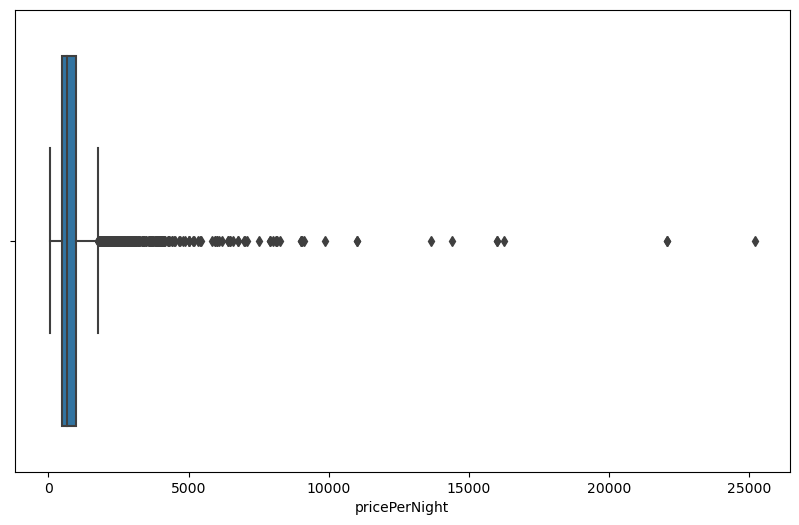

In [19]:
# Handling with outliers:

showOutliers(df, "pricePerNight")

It is clear to see here that the column "pricePerNight" has 360 outliers, according to the 1.5IQR method.

Now, we need to understand whether the outliers are really true or not. If so, we should leave them as they are. If not, the outliers must be handled and replaced by the median, the most frequent value or the next cell - depends on the column type.

According to our data from Booking.com, there is a hotel that costs 25,000 NIS per night. There is no doubt that this is an outlier, as the average price is 989 NIS per night (25 times smaller!). However, we can see that this is a real price on Booking.com, so these cells should not be changed.

In [28]:
# Export clean data set to csv:
df.to_csv("Data/2-dataHandling.csv", index=False)

In [20]:
# Load data set from csv (for personal use):
df = pd.read_csv("Data/2-dataHandling.csv")

## Back to Step 2: Data Acquisition

<div style="display: flex; align-items: center;">
  <h3 style="flex: 1; margin-top: -10px; font-size: 25px;">
    Data Acquisition by API
  </h3>
  <p style="margin-left: auto;">
    <img src="images/api.png" alt="Image Alt Text" width="200px" />
  </p>
</div>

Now, we need to go back to step 2 - data acquisition.

At this point we will get the data about the distance of each hotel's city to TLV. This could not be done before step 3 of Data Handling, because at that stage we created a new column and extracted the city name from the entire address.

The "City" column will now help us get the distance from the hotel city to TLV.

#### Auxiliary Functions

In these two following function we calculate the distance between Tel-Aviv to another city.
The calculation using an API which called GEODB in order to get the city ID and to find the distance.

In [21]:
def getCityID(cityName):
    
    # Set up the API endpoint URL
    url = "https://wft-geo-db.p.rapidapi.com/v1/geo/cities"

    # Set your API key and headers
    api_key = "b357d38c99mshac61197df8fd7c2p1d5cd7jsn2bfe93de690c"
    headers = {
        "X-RapidAPI-Key": api_key,
        "X-RapidAPI-Host": "wft-geo-db.p.rapidapi.com"
    }

    # Set the query parameters for the country code and name
    params = {
        "countryIds": "IL",
        "namePrefix": cityName
    }

    # Send GET request to the API
    time.sleep(1.5)
    response = requests.get(url, headers=headers, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the response JSON
        data = response.json()

        # Check if any cities were found
        if data["data"]:
            # Get the city ID from the first result
            city_id = data["data"][0]["id"]
            print("City ID:", city_id)
            return city_id
        else:
            print("No matching cities found.")
            return np.nan
    else:
        print("Error:", response.status_code)
        print(response.json())
        return np.nan

In [22]:
def getCityDistance(cityID):

    if np.isnan(cityID):
        print()
        return cityID

    time.sleep(1.5)
    url = "https://wft-geo-db.p.rapidapi.com/v1/geo/cities/54067/distance"

    querystring = {"fromCityId":"54067","distanceUnit":"km","toCityId":cityID}

    headers = {
        "X-RapidAPI-Key": "b357d38c99mshac61197df8fd7c2p1d5cd7jsn2bfe93de690c",
        "X-RapidAPI-Host": "wft-geo-db.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)

    data = response.json()
    print(data)
    print()

    if "data" in data:
        return data["data"]
    else:
        return np.nan

In [23]:
def finalDistance(cityName):
    return getCityDistance(getCityID(cityName))

In [33]:
def addDisTlvCol(df):

    newDf = df.copy()
    newDf["distanceTlv"] = newDf["City"].apply(finalDistance)

    return newDf

#### Main Function

In [24]:
# Create a dataframe of unique cities:

cities = pd.DataFrame(df["City"]).drop_duplicates()
cities

,City
0,Eilat
1,Ein Gedi
2,Herzelia
3,Merom Golan
4,Ein Bokek
...,...
3587,Nof Kinneret
3591,Qiryat Sara
3605,Rama
3606,Kammon


In [ ]:
cities = addDisTlvCol(cities)

In [26]:
cities = pd.read_csv("Data/3-citiesWithDistance.csv")
df = pd.read_csv("Data/2-dataHandling.csv")

In [27]:
# Export Cities data set to csv:
cities.to_csv("Data/3-citiesWithDistance.csv", index=False)

# vLookup in cities dataset to df dataset:
df = pd.merge(df, cities, on='City', how='left')

# Data handling:
df = convertToNum(df,["distanceTlv"])

In [28]:
# Calculating percentage of missing distanceTlv:
df["distanceTlv"].isna().sum() / len(df["distanceTlv"]) * 100

29.426365140650855

In [29]:
# Checking problematic cities:

problematicDf = df[pd.isna(df["distanceTlv"])]

problematicCities = pd.pivot_table(problematicDf, values="hotelName", index="City", aggfunc="count").sort_values("hotelName", ascending=False)

In [30]:
problematicCities

,hotelName
City,
Akko,99
Nahariyya,66
Beer Sheva,52
Masade,31
Had Nes,26
...,...
Kibbutz Shefayim,1
Nizzane Sinay,1
Gerofit,1


In [40]:
# Export problematic cities to csv:
problematicCities.to_csv("Data/5-problmaticCities.csv")

In [129]:
# Export data set to csv:
df.to_csv("Data/4-dataAPI.csv", index=False)

In [31]:
# Load data set from csv (for personal use):
df = pd.read_csv("Data/4-dataAPI.csv")

In [32]:
# Import the dictionary we made:
fixedNames = pd.read_csv("Data/6-problmaticCitiesFixed.csv")

In [33]:
fixedNames

,City,CityAuxialary,FixCity
0,Akko,Akko,Acre
1,Nahariyya,Nahariyya,Nahariya
2,Beer Sheva,Beer Sheva,Beer Sheva
3,Masade,Masade,Masada
4,Had Nes,Had Nes,Had Nes
...,...,...,...
351,Hurfeish,Hurfeish,Hurfeish
352,Shezor,Shezor,Shezor
353,Fassuta,Fassuta,Fassuta
354,Rama,Rama,Rama


In [34]:
# Create a dictionary to replace the problematic names:

fixedNames = dict(zip(fixedNames['City'], fixedNames['FixCity']))
fixedNames

{'Akko': 'Acre',
 'Nahariyya': 'Nahariya',
 'Beer Sheva': 'Beer Sheva',
 'Masade': 'Masada',
 'Had Nes': 'Had Nes',
 'Kefar Weradim': 'Kfar Vardim',
 'Yeroham': 'Yeruham',
 'Zikhron Yaaqov': "Zichron Ya'akov",
 'Herzelia ': 'Herzliya',
 'Moshav Ramot': 'Moshav Ramot ',
 'Qiryat Shemona': 'Kiryat Shmona',
 'Ein Kinya': 'Ein Kiniya',
 'Qasrine': 'Kasserine',
 'Mishmar Hayardin': 'Mishmar Hiridin',
 'Rishon LeZiyyon': 'Rishon LeZion',
 'Maalot Tarshiha': "Ma'alot Tarshikha",
 'Petah Tiqwa': 'Petah Tikva',
 'Metulla': 'Metula',
 'Rechovot': 'Rehovot',
 'Herzliyya B': 'Herzliya b',
 'Shaal': 'that',
 'Raananna': 'Raanana',
 'Bet Shean': 'Beit Shean',
 'Kefar Blum': 'Kfar Bloom',
 'Ein el Asad': 'Ain Al Asad',
 'Shear Yashuv': 'Shaar Yishov',
 'Odem': 'Odem',
 'Tsivon': 'Tsivon',
 'Yavneel': 'Yavnal',
 'Neot Golan': 'Naot Golan',
 'Daliyat el Karmil': 'Dalit Al Karmil',
 'El-Rom': 'al-Rum',
 'Kefar Szold': 'Kfar Sold',
 'Givat Yoav': 'Givat Yoav',
 'Oshrat': 'happy',
 'Ovnat': 'Onat',
 'Yeso

In [35]:
# Restoring data set to before API:
df = pd.read_csv("Data/2-dataHandling.csv")

In [36]:
df

,hotelName,hotelAddress,Street,City,hotelDescription,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean
0,Melio Hotel Eilat,"Sderot Hativat HaNegev 20, Eilat",Sderot Hativat HaNegev 20,Eilat,"Set in Eilat, within 1.2 km of Kisuski Beach a...",286.0,7.9,8.4,7.8,8.4
1,Badolina Ein Gedi Glamping,"Ein Gedi Street, Ein Gedi",Ein Gedi Street,Ein Gedi,"Dead Sea Camping is set in Ein Gedi, within 1 ...",130.0,8.5,7.7,9.2,8.3
2,Daniel Herzliya Hotel,"60 Ramat Yam Street, Herzelia",60 Ramat Yam Street,Herzelia,"Set right on the beach, in the heart of Herzli...",777.0,7.9,7.5,9.0,8.0
3,Merom Golan Resort,"Kibbutz Merom Golan, Merom Golan",Kibbutz Merom Golan,Merom Golan,Merom Golan Resort offers quiet mountain accom...,983.0,8.7,7.9,9.4,8.9
4,Leonardo Club Hotel Dead Sea - All Inclusive,"Ein Bokek (Dead sea), Ein Bokek",Ein Bokek (Dead sea),Ein Bokek,This all-inclusive deluxe hotel is set a priva...,1308.0,7.7,7.4,8.7,7.5
...,...,...,...,...,...,...,...,...,...,...
3621,צימר נוף העמק,"28 נוף העמק, Nof Kinneret",28 נוף העמק,Nof Kinneret,"Situated in Nof Kinneret, 4.7 km from Israel B...",1454.0,8.0,10.0,10.0,10.0
3622,Supreme 4BR Villa With Garden and Sea View,"55 Jabotinski Street, Nahariyya",55 Jabotinski Street,Nahariyya,Situated in Nahariyya and only 400 m from HaDe...,4087.0,8.7,8.8,9.3,9.2
3623,Blue lake luxury villa for families,"עין אל אסד, Ein el Asad",עין אל אסד,Ein el Asad,Located in Ein el Asad and only 37 km from The...,4160.0,6.0,8.8,9.3,9.2
3624,Paradise by the sea,"דוגית, Nahariyya",דוגית,Nahariyya,"Paradise by the sea is located in Nahariyya, 1...",2880.0,8.7,8.8,9.3,9.2


In [37]:
# Replacing every wrong city name according to the dictionary above:

df['City'] = df['City'].map(fixedNames)

In [38]:
df

,hotelName,hotelAddress,Street,City,hotelDescription,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean
0,Melio Hotel Eilat,"Sderot Hativat HaNegev 20, Eilat",Sderot Hativat HaNegev 20,Eilat,"Set in Eilat, within 1.2 km of Kisuski Beach a...",286.0,7.9,8.4,7.8,8.4
1,Badolina Ein Gedi Glamping,"Ein Gedi Street, Ein Gedi",Ein Gedi Street,Ein Gedi,"Dead Sea Camping is set in Ein Gedi, within 1 ...",130.0,8.5,7.7,9.2,8.3
2,Daniel Herzliya Hotel,"60 Ramat Yam Street, Herzelia",60 Ramat Yam Street,Herzliya,"Set right on the beach, in the heart of Herzli...",777.0,7.9,7.5,9.0,8.0
3,Merom Golan Resort,"Kibbutz Merom Golan, Merom Golan",Kibbutz Merom Golan,Marom Golan,Merom Golan Resort offers quiet mountain accom...,983.0,8.7,7.9,9.4,8.9
4,Leonardo Club Hotel Dead Sea - All Inclusive,"Ein Bokek (Dead sea), Ein Bokek",Ein Bokek (Dead sea),Ein Bokek,This all-inclusive deluxe hotel is set a priva...,1308.0,7.7,7.4,8.7,7.5
...,...,...,...,...,...,...,...,...,...,...
3621,צימר נוף העמק,"28 נוף העמק, Nof Kinneret",28 נוף העמק,Nof Kinneret,"Situated in Nof Kinneret, 4.7 km from Israel B...",1454.0,8.0,10.0,10.0,10.0
3622,Supreme 4BR Villa With Garden and Sea View,"55 Jabotinski Street, Nahariyya",55 Jabotinski Street,Nahariya,Situated in Nahariyya and only 400 m from HaDe...,4087.0,8.7,8.8,9.3,9.2
3623,Blue lake luxury villa for families,"עין אל אסד, Ein el Asad",עין אל אסד,Ain Al Asad,Located in Ein el Asad and only 37 km from The...,4160.0,6.0,8.8,9.3,9.2
3624,Paradise by the sea,"דוגית, Nahariyya",דוגית,Nahariya,"Paradise by the sea is located in Nahariyya, 1...",2880.0,8.7,8.8,9.3,9.2


In [39]:
# Export our fixed-cities data set:
df.to_csv("Data/8-fullDataWithGoodCity.csv", index=False)

In [40]:
# Create a dataframe of unique cities:

cities = pd.DataFrame(df["City"]).drop_duplicates()
cities

,City
0,Eilat
1,Ein Gedi
2,Herzliya
3,Marom Golan
4,Ein Bokek
...,...
3587,Nof Kinneret
3591,Kiryat Sara
3605,Rama
3606,Kamon


In [54]:
cities = addDisTlvCol(cities)

City ID: 3707256
{'data': 281.8}

City ID: 3018456
{'data': 90.2}

City ID: 54484
{'data': 10.2}

No matching cities found.

City ID: 3452478
{'data': 112.4}

No matching cities found.

City ID: 53979
{'data': 122.0}

City ID: 3452755
{'data': 163.2}

No matching cities found.

City ID: 3022932
{'data': 91.5}

City ID: 2969800
{'data': 106.7}

City ID: 54154
{'data': 14.6}

City ID: 54011
{'data': 98.3}

City ID: 3057858
{'data': 79.2}

No matching cities found.

City ID: 54357
{'data': 84.6}

No matching cities found.

No matching cities found.

City ID: 54006
{'data': 152.7}

No matching cities found.

No matching cities found.

City ID: 54635
{'data': 107.6}

No matching cities found.

City ID: 3645003
{'data': 69.7}

No matching cities found.

City ID: 3081365
{'data': 112.9}

City ID: 3040256
{'data': 130.5}

City ID: 54427
{'data': 105.4}

City ID: 3090993
{'data': 63.3}

No matching cities found.

City ID: 54151
{'data': 106.8}

No matching cities found.

City ID: 3183367
{'data

In [41]:
cities

,City
0,Eilat
1,Ein Gedi
2,Herzliya
3,Marom Golan
4,Ein Bokek
...,...
3587,Nof Kinneret
3591,Kiryat Sara
3605,Rama
3606,Kamon


In [56]:
# Export cities to csv:
cities.to_csv("Data/9-fullCorrectCitiesWithDis.csv", index=False)

In [42]:
# Import cities:
cities = pd.read_csv("Data/9-fullCorrectCitiesWithDis.csv")

In [43]:

df = df.merge(cities[['City', 'distanceTlv']], on='City', how='left')
df

,hotelName,hotelAddress,Street,City,hotelDescription,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean,distanceTlv
0,Melio Hotel Eilat,"Sderot Hativat HaNegev 20, Eilat",Sderot Hativat HaNegev 20,Eilat,"Set in Eilat, within 1.2 km of Kisuski Beach a...",286.0,7.9,8.4,7.8,8.4,281.8
1,Badolina Ein Gedi Glamping,"Ein Gedi Street, Ein Gedi",Ein Gedi Street,Ein Gedi,"Dead Sea Camping is set in Ein Gedi, within 1 ...",130.0,8.5,7.7,9.2,8.3,90.2
2,Daniel Herzliya Hotel,"60 Ramat Yam Street, Herzelia",60 Ramat Yam Street,Herzliya,"Set right on the beach, in the heart of Herzli...",777.0,7.9,7.5,9.0,8.0,10.2
3,Merom Golan Resort,"Kibbutz Merom Golan, Merom Golan",Kibbutz Merom Golan,Marom Golan,Merom Golan Resort offers quiet mountain accom...,983.0,8.7,7.9,9.4,8.9,NaN
4,Leonardo Club Hotel Dead Sea - All Inclusive,"Ein Bokek (Dead sea), Ein Bokek",Ein Bokek (Dead sea),Ein Bokek,This all-inclusive deluxe hotel is set a priva...,1308.0,7.7,7.4,8.7,7.5,112.4
...,...,...,...,...,...,...,...,...,...,...,...
3621,צימר נוף העמק,"28 נוף העמק, Nof Kinneret",28 נוף העמק,Nof Kinneret,"Situated in Nof Kinneret, 4.7 km from Israel B...",1454.0,8.0,10.0,10.0,10.0,NaN
3622,Supreme 4BR Villa With Garden and Sea View,"55 Jabotinski Street, Nahariyya",55 Jabotinski Street,Nahariya,Situated in Nahariyya and only 400 m from HaDe...,4087.0,8.7,8.8,9.3,9.2,106.8
3623,Blue lake luxury villa for families,"עין אל אסד, Ein el Asad",עין אל אסד,Ain Al Asad,Located in Ein el Asad and only 37 km from The...,4160.0,6.0,8.8,9.3,9.2,NaN
3624,Paradise by the sea,"דוגית, Nahariyya",דוגית,Nahariya,"Paradise by the sea is located in Nahariyya, 1...",2880.0,8.7,8.8,9.3,9.2,106.8


In [44]:
df = convertToNum(df, ["distanceTlv"])

In [45]:
# Calculating percentage of missing distanceTlv:
df["distanceTlv"].isna().sum() / len(df["distanceTlv"]) * 100

19.442912300055156

In [46]:
# Replacing all the missing distances with the median:
df = replaceMissingValues(df)
df

,hotelName,hotelAddress,Street,City,hotelDescription,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean,distanceTlv
0,Melio Hotel Eilat,"Sderot Hativat HaNegev 20, Eilat",Sderot Hativat HaNegev 20,Eilat,"Set in Eilat, within 1.2 km of Kisuski Beach a...",286.0,7.9,8.4,7.8,8.4,281.8
1,Badolina Ein Gedi Glamping,"Ein Gedi Street, Ein Gedi",Ein Gedi Street,Ein Gedi,"Dead Sea Camping is set in Ein Gedi, within 1 ...",130.0,8.5,7.7,9.2,8.3,90.2
2,Daniel Herzliya Hotel,"60 Ramat Yam Street, Herzelia",60 Ramat Yam Street,Herzliya,"Set right on the beach, in the heart of Herzli...",777.0,7.9,7.5,9.0,8.0,10.2
3,Merom Golan Resort,"Kibbutz Merom Golan, Merom Golan",Kibbutz Merom Golan,Marom Golan,Merom Golan Resort offers quiet mountain accom...,983.0,8.7,7.9,9.4,8.9,84.6
4,Leonardo Club Hotel Dead Sea - All Inclusive,"Ein Bokek (Dead sea), Ein Bokek",Ein Bokek (Dead sea),Ein Bokek,This all-inclusive deluxe hotel is set a priva...,1308.0,7.7,7.4,8.7,7.5,112.4
...,...,...,...,...,...,...,...,...,...,...,...
3621,צימר נוף העמק,"28 נוף העמק, Nof Kinneret",28 נוף העמק,Nof Kinneret,"Situated in Nof Kinneret, 4.7 km from Israel B...",1454.0,8.0,10.0,10.0,10.0,84.6
3622,Supreme 4BR Villa With Garden and Sea View,"55 Jabotinski Street, Nahariyya",55 Jabotinski Street,Nahariya,Situated in Nahariyya and only 400 m from HaDe...,4087.0,8.7,8.8,9.3,9.2,106.8
3623,Blue lake luxury villa for families,"עין אל אסד, Ein el Asad",עין אל אסד,Ain Al Asad,Located in Ein el Asad and only 37 km from The...,4160.0,6.0,8.8,9.3,9.2,84.6
3624,Paradise by the sea,"דוגית, Nahariyya",דוגית,Nahariya,"Paradise by the sea is located in Nahariyya, 1...",2880.0,8.7,8.8,9.3,9.2,106.8


In [91]:
# Export data set to csv:
df.to_csv("Data/10-allTheData.csv", index=False)

In [47]:
# Import:
df = pd.read_csv("Data/10-allTheData.csv")

## Step 4: EDA

the graph below present two columns one=x and the other=y, it consider in every 50 values

In [48]:
#function which make a x y graph that consider every n values in two columns

def graphXYN(colX,colY,n,df):
        #graph x y which consider every 10 values
    df1 = df.copy()
    # Sort the dataframe based on the x-column values
    df1 = df.sort_values(colX)

    # Downsample the data by selecting every nth data point
    # Adjust the value of n as needed #means that every n  data point will be selected for plotting, while the others will be skipped
    df_downsampled = df1.iloc[::n]

    # Apply a moving average to smooth the y-column values
    window_size = 3  # Adjust the window size as needed
    df_downsampled['y_column_smoothed'] = df_downsampled[colY].rolling(window_size, center=True).mean()

    # Plot the downsampled and smoothed data
    plt.plot(df_downsampled[colX], df_downsampled['y_column_smoothed'], marker='o', linestyle='-', color='blue')

    # Adding labels and title
    plt.xlabel(colX)
    plt.ylabel(colY)
    plt.title(f'Line Chart ({colX} vs {colY})')  # Dynamic graph title based on column names


    # Displaying the plot
    plt.show()


C:\Users\AMIT\AppData\Local\Temp\ipykernel_28060\3269627404.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_downsampled['y_column_smoothed'] = df_downsampled[colY].rolling(window_size, center=True).mean()


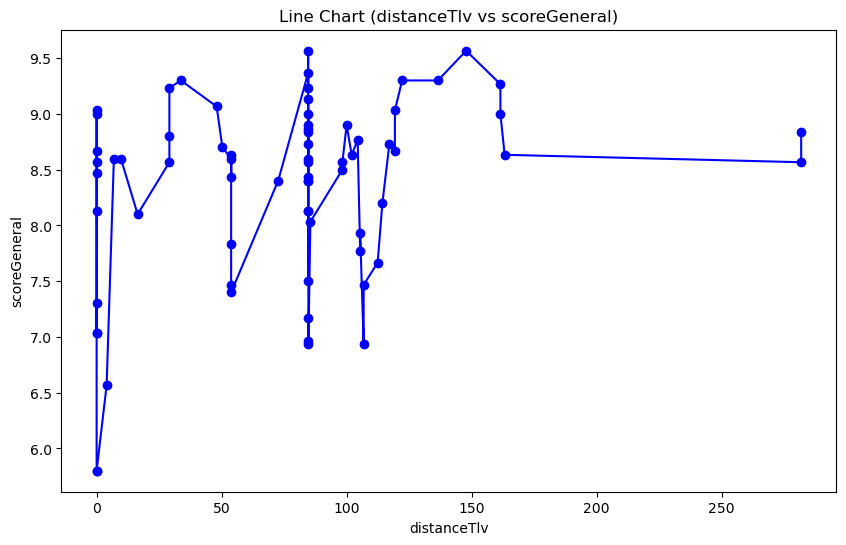

In [49]:
graphXYN('distanceTlv','scoreGeneral',50,df)

the graph below present two columns one=x and the other=y, it considers all the values

In [50]:

def graphXY(colX,colY,df):
    df1 = df.copy()

    # Assuming you have a dataframe named 'df' with columns 'x_column' and 'y_column'

    # Sort the dataframe based on the x-column values
    df1 = df1.sort_values(colX)

    # Plot the line chart with all data points
    plt.plot(df1[colX], df1[colY], marker='o', linestyle='-', color='blue')

    # Adding labels and title
    plt.xlabel(colX)
    plt.ylabel(colY)
    plt.title(f'Line Chart ({colX} vs {colY})')  # Dynamic graph title based on column names

    # Displaying the plot
    plt.show()



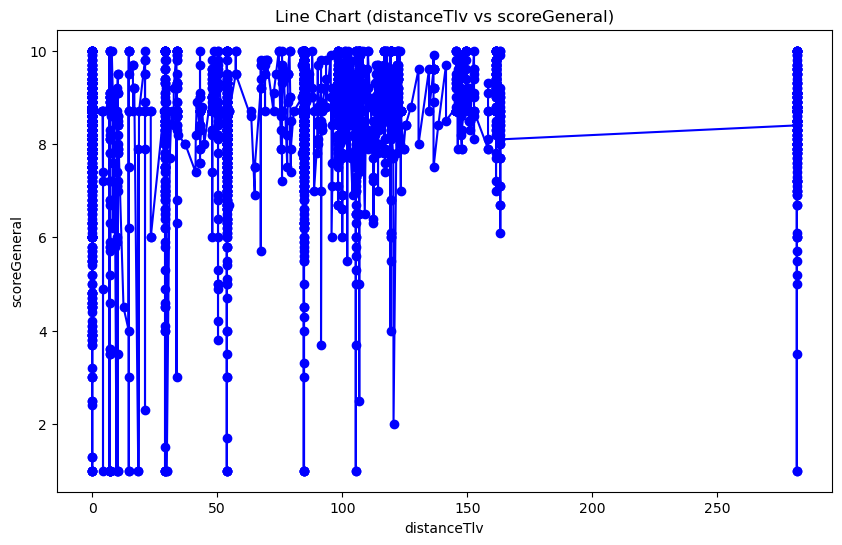

In [51]:
graphXY('distanceTlv','scoreGeneral',df)

this graph show the frequency of prices

In [52]:
def frequencyCol(df,col):
    # Plot a histogram of the column
    plt.hist(df[col], bins=10)  # Adjust the number of bins as needed

    # Adding labels and title
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    # plt.title('Histogram of')
    plt.title(f'Histogram of {col}')



    # Displaying the plot
    plt.show()


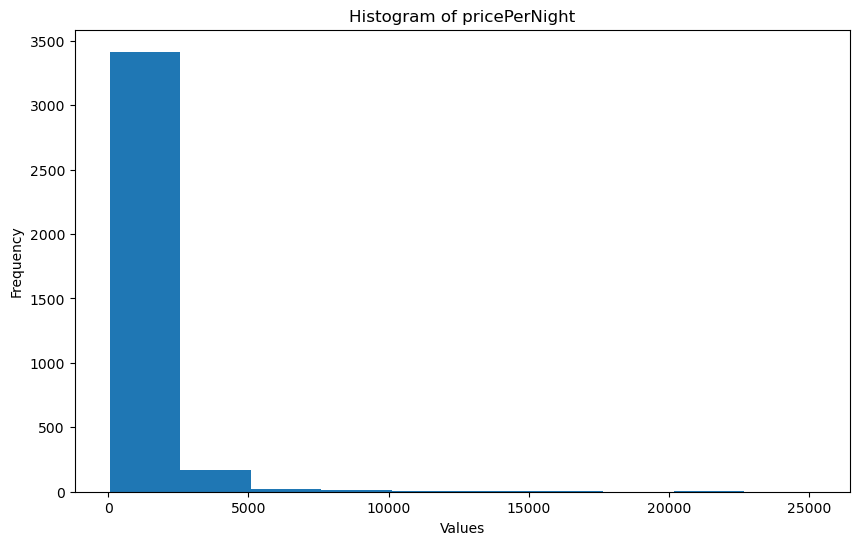

In [53]:
frequencyCol(df,'pricePerNight')

the graph below show us the corolation between all the columns

In [104]:
def corGraph(df):
    df1 = df.copy()

    # Compute the correlation matrix
    corr_matrix = df1.corr()

    # Create a heatmap of the correlation matrix
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

    # Adding title
    plt.title('Correlation Matrix Heatmap')

    # Displaying the plot
    plt.show()

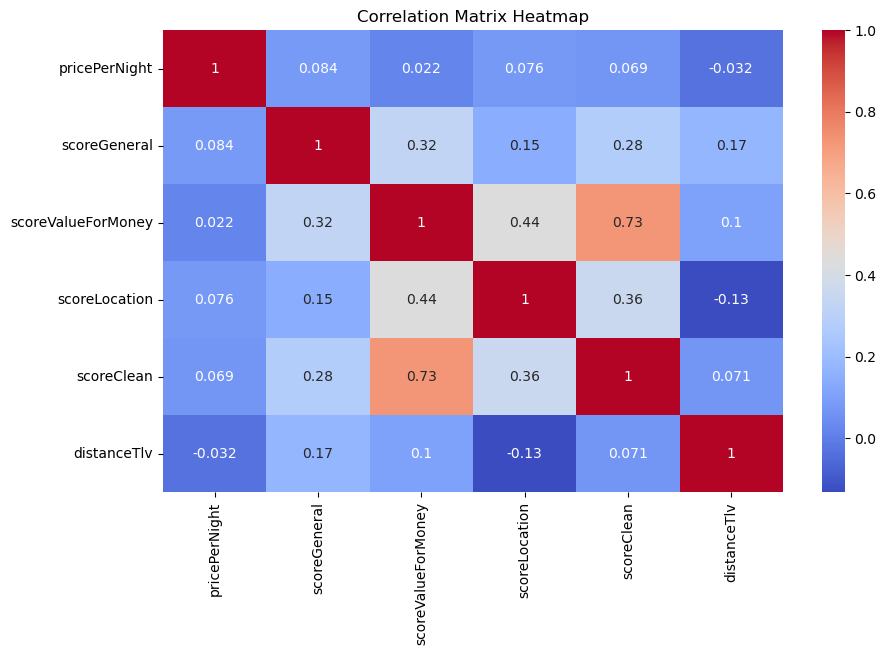

In [105]:
corGraph(df)

The graph below can show us the range of the prices between the common cities.

In [54]:
def citiesPrices(df,n):
    # Filter the dataframe to include only the top n cities by occurrences
    top_cities = df['City'].value_counts().nlargest(n).index.tolist()
    filtered_df = df[df['City'].isin(top_cities)]

    # Create a boxplot of pricePerNight for the selected cities
    sns.violinplot(data=filtered_df, x='City', y='pricePerNight',whis =3)

    # Adding title
    plt.title('Boxplot of pricePerNight for Top Cities')

    # Displaying the plot
    plt.show()


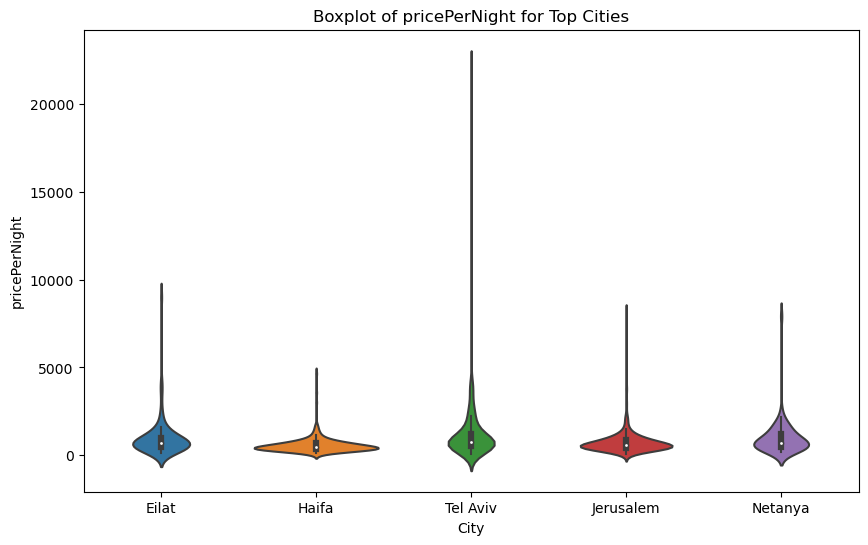

In [55]:
citiesPrices(df,5)

The graph below shows 3d between 3 vals.

In [56]:
def graphXYZ(df,colX,colY,colZ):
    df1 = df.copy()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x = df1[colX]
    y = df1[colY]
    z = df1[colZ]
    
    ax.scatter3D(x, y, z, c=z, depthshade=False)
    
    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.set_zlabel(colZ)
    
    plt.show()

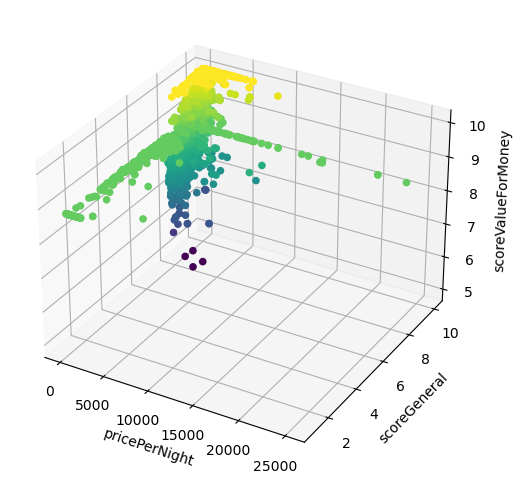

In [57]:
graphXYZ(df,'pricePerNight','scoreGeneral','scoreValueForMoney')

<div style="display: flex; align-items: center;">
  <div>
  <p style="flex: 1; margin-top: -10px; margin-right: 10px;">
    When we started working on this project, our goal was to check if there is a relationship between a city's distance from TLV, and its price. After this EDA step, we realize (especially thanks to the heatmap diagram) that there is no strong correlation between these two features. We believe that machine learning will not be sufficient either. Therefore, we decided to change our research questions based on the EDA we did.
  </p>
  <p>
    As we can see in the heatmap graph, there is a pretty good correlation between scoreValueForMoney and scoreClean. It can be concluded from this information that probably the Israeli people consider the cleanliness of the room to be a very important thing that affects the value for money. We believe that due to this good correlation between these features, the built model will be good enough.
  </p>
  <p>
    Even though we spent time getting the information from the API and realized we wouldn't use it in the end, it let us know we were wrong and prevent us from using Machine Learning in this feature. This effort was not in vain.
  </p>
  </div>
  <p style="margin-left: auto;">
    <img src="images/disappointed.gif" alt="Image Alt Text" width="200px" />
  </p>
</div>


## Step 5: Machine Learning

- **generalScore column:** scaled 1-10
- **scores columns:** scaled 5-10
- **pricePerNight column:** scaled up to 25,000.

For our data to be good for conclusions with Machine Learning, we need to scale the data.

Let's do that before starting ML.

In [106]:
columnsToScale = ["pricePerNight", "scoreGeneral", "scoreValueForMoney", "scoreLocation", "scoreClean", "distanceTlv"]
scaler = MinMaxScaler(feature_range=(0, 1))

df[columnsToScale] = scaler.fit_transform(df[columnsToScale])

In [107]:
df.describe()

,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean,distanceTlv
count,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000
mean,0.036972,0.825562,0.759333,0.844848,0.822846,0.280130
std,0.050803,0.156101,0.136193,0.108921,0.130544,0.223558
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.016945,0.788889,0.700000,0.820000,0.760000,0.103708
50%,0.024383,0.855556,0.760000,0.860000,0.840000,0.300213
75%,0.037391,0.911111,0.840000,0.900000,0.900000,0.374024
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [108]:
# Export data set to csv:
df.to_csv("Data/11-scaledData.csv", index=False)

At this point we want to predict the valueForMoney score of a hotel, based on its clean score.

Since we want to predict an exact number, we need to use the Linear Regression method.

### Auxiliary Functions

In [109]:
# Create a scatterplot easily:

def showScatterPlot(df, xColumn, yCols, yCaption):

    markers = [".","s","P", "*", "D"]
    colors = ["r", "b", "k"]

    for index, yCol in enumerate(yCols):
        plt.scatter(x=df[xColumn],y=df[yCol],c=colors[index%3],marker=markers[index%5],label=yCol)

    plt.legend(numpoints=1,loc=4)
    plt.xlabel(xColumn)
    plt.ylabel(yCaption)
    plt.show()

In [110]:
# Create a scatterplot with predict of model:

def showScatterPlotPredict(m, df, xColumn, yColumn):
    
    x = df[[xColumn]].values
    y = df[yColumn].values

    plt.scatter(x=df[xColumn], y=df[yColumn], c='k', marker='*')
    plt.plot(df[xColumn], m.predict(x), 'k', color='blue', linewidth=3)

    plt.xlabel(xColumn)
    plt.ylabel(yColumn)
    plt.show()

In [182]:
# Create a scatterplot easily:

def columnsGraph(dict, caption):

    labels = list(dict.keys())
    values = list(dict.values())
    
    plt.bar(labels, values)
    plt.title(caption)
    plt.show()

### Main Function

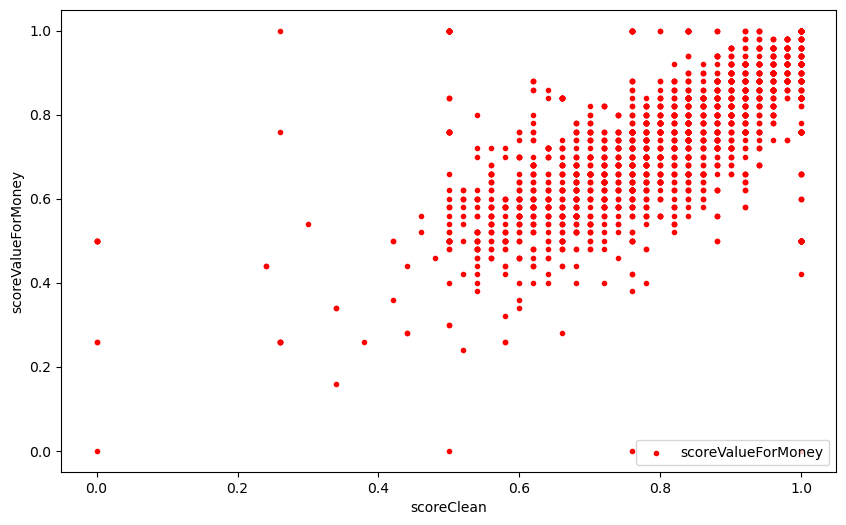

In [128]:
numericDf = df[["pricePerNight", "scoreGeneral", "scoreValueForMoney", "scoreLocation", "scoreClean", "distanceTlv"]].copy()

# Basic data visualisation for hints on regression:
showScatterPlot(numericDf, "scoreClean", ["scoreValueForMoney"], "scoreValueForMoney")

According to the graph, it can be seen that there may be a linear regression relationship for these columns.

/var/folders/py/k7_4fcs533zgdg_c6z17hn8r0000gn/T/ipykernel_13049/2204775623.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(df[xColumn], m.predict(x), 'k', color='blue', linewidth=3)


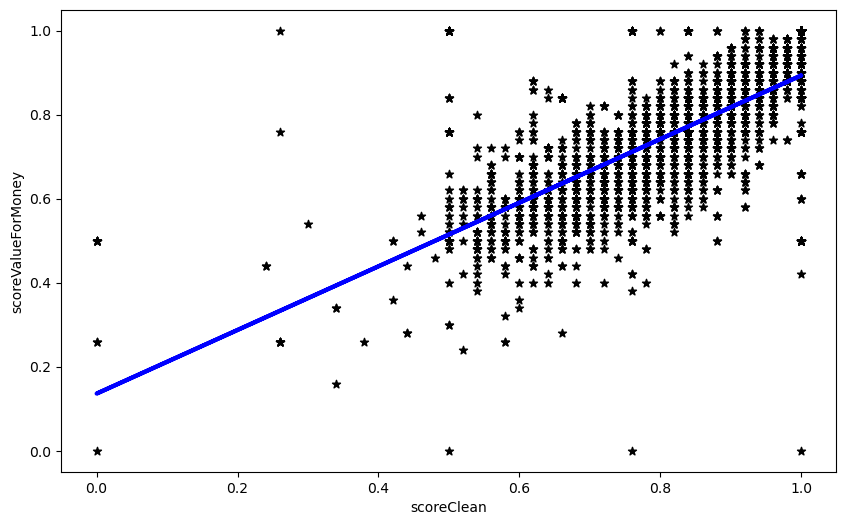

In [129]:
x = numericDf[["scoreClean"]].values
y = numericDf["scoreValueForMoney"].values

m = linear_model.LinearRegression().fit(x, y)

showScatterPlotPredict(m, numericDf, "scoreClean", "scoreValueForMoney")

In [130]:
# What is the math equation of the line?

print("b1:",m.coef_)
print("b0:",m.intercept_)

b1: [0.7575161]
b0: 0.13601341823530688


#### Evaluation

In [146]:
# Calculating squared errors:
mean_squared_error(numericDf["scoreValueForMoney"].tolist(), m.predict(numericDf["scoreValueForMoney"].values.reshape(-1, 1)).flatten()) * len(numericDf["scoreValueForMoney"].tolist())

12.347049596686155

Is our model good enough or not? The number we see above is absolute, but not relative... We don't know whether it's good or not. Let's calculate R2 score:

In [132]:
r2_score(numericDf["scoreValueForMoney"].tolist(), m.predict(numericDf["scoreValueForMoney"].values.reshape(-1, 1)).flatten())

0.8163701260002006

#### Checking other features

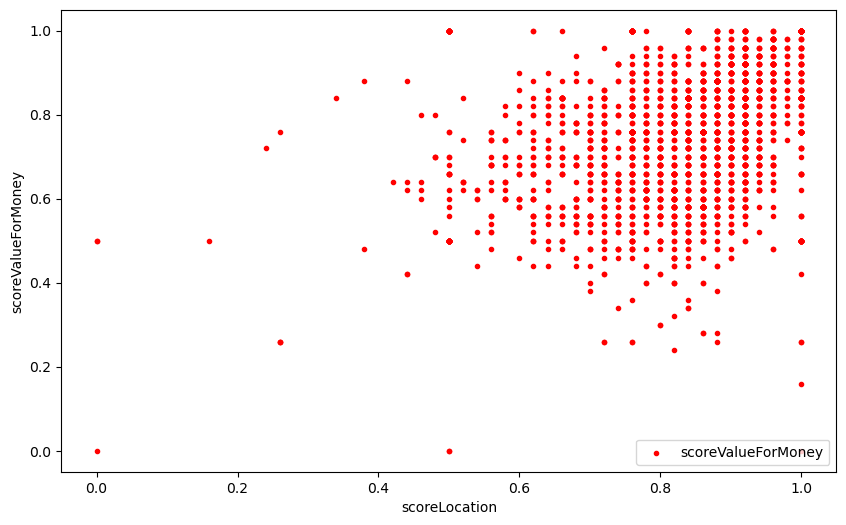

In [168]:
# Basic data visualisation for hints on regression:
showScatterPlot(numericDf, "scoreLocation", ["scoreValueForMoney"], "scoreValueForMoney")

/var/folders/py/k7_4fcs533zgdg_c6z17hn8r0000gn/T/ipykernel_13049/2204775623.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(df[xColumn], m.predict(x), 'k', color='blue', linewidth=3)


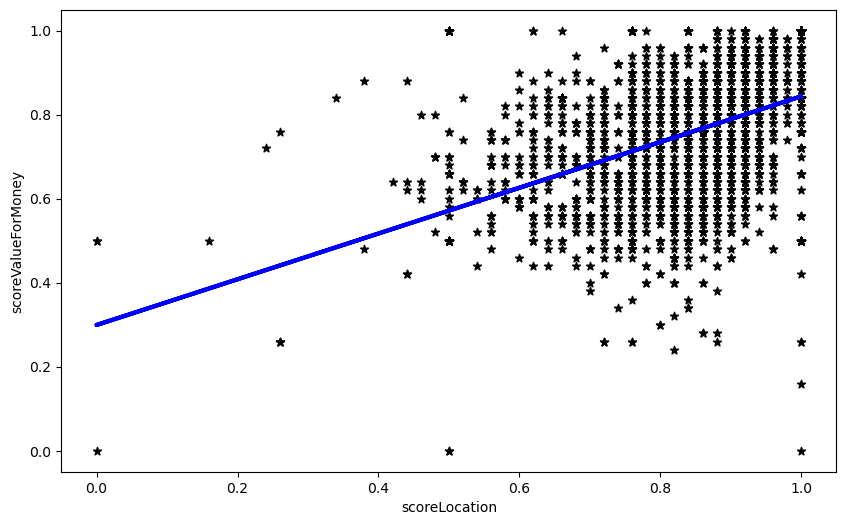

In [169]:
x1 = numericDf[["scoreLocation"]].values
y1 = numericDf["scoreValueForMoney"].values

m1 = linear_model.LinearRegression().fit(x1, y1)

showScatterPlotPredict(m1, numericDf, "scoreLocation", "scoreValueForMoney")

In [170]:
# What is the math equation of the line?

print("b1:",m1.coef_)
print("b0:",m1.intercept_)

b1: [0.54440621]
b0: 0.29939192927972175


In [171]:
# Calculating R2:
r2_score(numericDf["scoreValueForMoney"].tolist(), m1.predict(numericDf["scoreValueForMoney"].values.reshape(-1, 1)).flatten())

0.6755527383807001

In practice, R2 will be negative whenever the model's predictions are worse than a constant function that always predicts the mean of the data. As we discovered on the EDA step, the prediction of pricePerNight (based on distanceTlv) is not good.

#### Multivariate Regression

At this point we want to check if we rely on additional features, the prediction improves. We will try to get a new mathematical equation that relies on several variables: 
$$
scoreValueForMoney = \beta_0 + \beta_1 * scoreClean + \beta_2 * pricePerNight + \beta_3 * scoreLocation
$$
Let's try it out:

In [172]:
lr = linear_model.LinearRegression()

xUnited = numericDf[["scoreClean", "pricePerNight", "scoreLocation"]]
yUnited = numericDf["scoreValueForMoney"]

lr.fit(X=xUnited, y=yUnited)

print("Slope:",lr.coef_)
print("Intercept:",lr.intercept_)

Slope: [ 0.68416409 -0.10250194  0.25655205]
Intercept: -0.0165870412051784


In [173]:
# Evaluating:
print("R2:",lr.score(xUnited,yUnited))

R2: 0.5646366441640369


Let's compare all our models and decide which one is better:

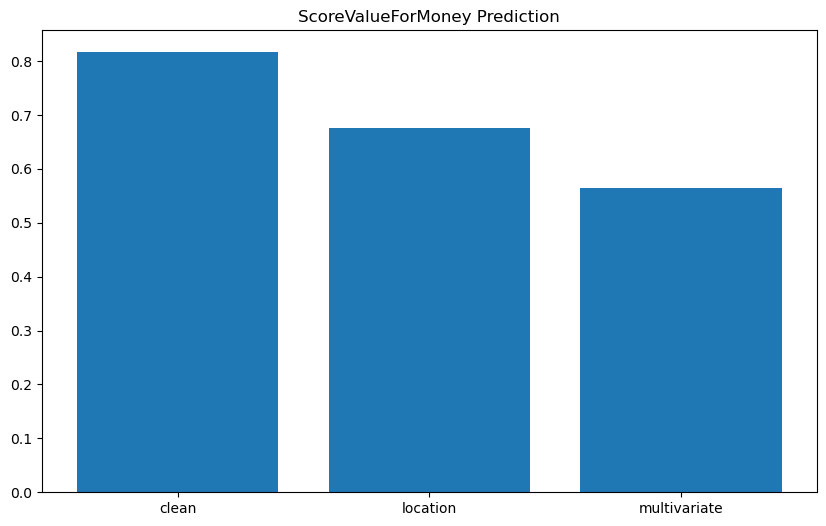

In [183]:
modelsData = {
    "clean": r2_score(numericDf["scoreValueForMoney"].tolist(), m.predict(numericDf["scoreValueForMoney"].values.reshape(-1, 1)).flatten()),
    "location": r2_score(numericDf["scoreValueForMoney"].tolist(), m1.predict(numericDf["scoreValueForMoney"].values.reshape(-1, 1)).flatten()),
    "multivariate": lr.score(xUnited,yUnited)
}

columnsGraph(modelsData, "ScoreValueForMoney Prediction")

We can see the the first model - of predicting the valueForMoney based on scoreClean, is the most reliable one.

## Summary

<div style="display: flex; align-items: center;">
<div>
  <p style="flex: 1; margin-right: 10px;">
    During our project, we wanted to check if there is a connection between the distance of a hotel from TLV and its price. First, we used the methods of crawling and API to get the data. After it, we handeled the data we had: removed duplicated hotels, completed missing data, converted some columns to numeric ones, deleting "/n" signs and others, extracting the city from the hotel address etc. After that, we had to make data analysis. Unfortunately, according to the data we got and the graphs we got using the plot library (especially the heatmap graph), we realized that our research question will give us good results. Therefore, we chose another research question. Finally, we created and fitted our model of linear regression to predict what the scoreValueForMoney will be, based on the cleaning score. We got a pretty good evaluation of 81%.
  </p>
  <p style="flex: 1; margin-right: 10px;">
    However, it's important to say that even though we got a conclusion, we can't trust the data 100%, because we got it from third side - like the API for distances, booking.com for the data of the hotels. We assume that the data is reliable, but we cannot know exactly.
  </p>
  </p>
  <p style="flex: 1; margin-right: 10px;">
    In personal aspect, we enjoyed working on this project. we enjoyed meeting each other and experiencing the methods of crawling and machine learning. We would definately recommend others to deal with Data Science.
  </p>
  </div>
  <p style="margin-left: auto;">
    <img src="images/final.gif" alt="Image Alt Text" width="200px" />
  </p>
</div>
